# V.1 Exploring the green reds


## a. Write a function that will plot a scatterplot matrix of your redwine data.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import csv
import random
import matplotlib.image as mpimg
import matplotlib.animation as animation
import os

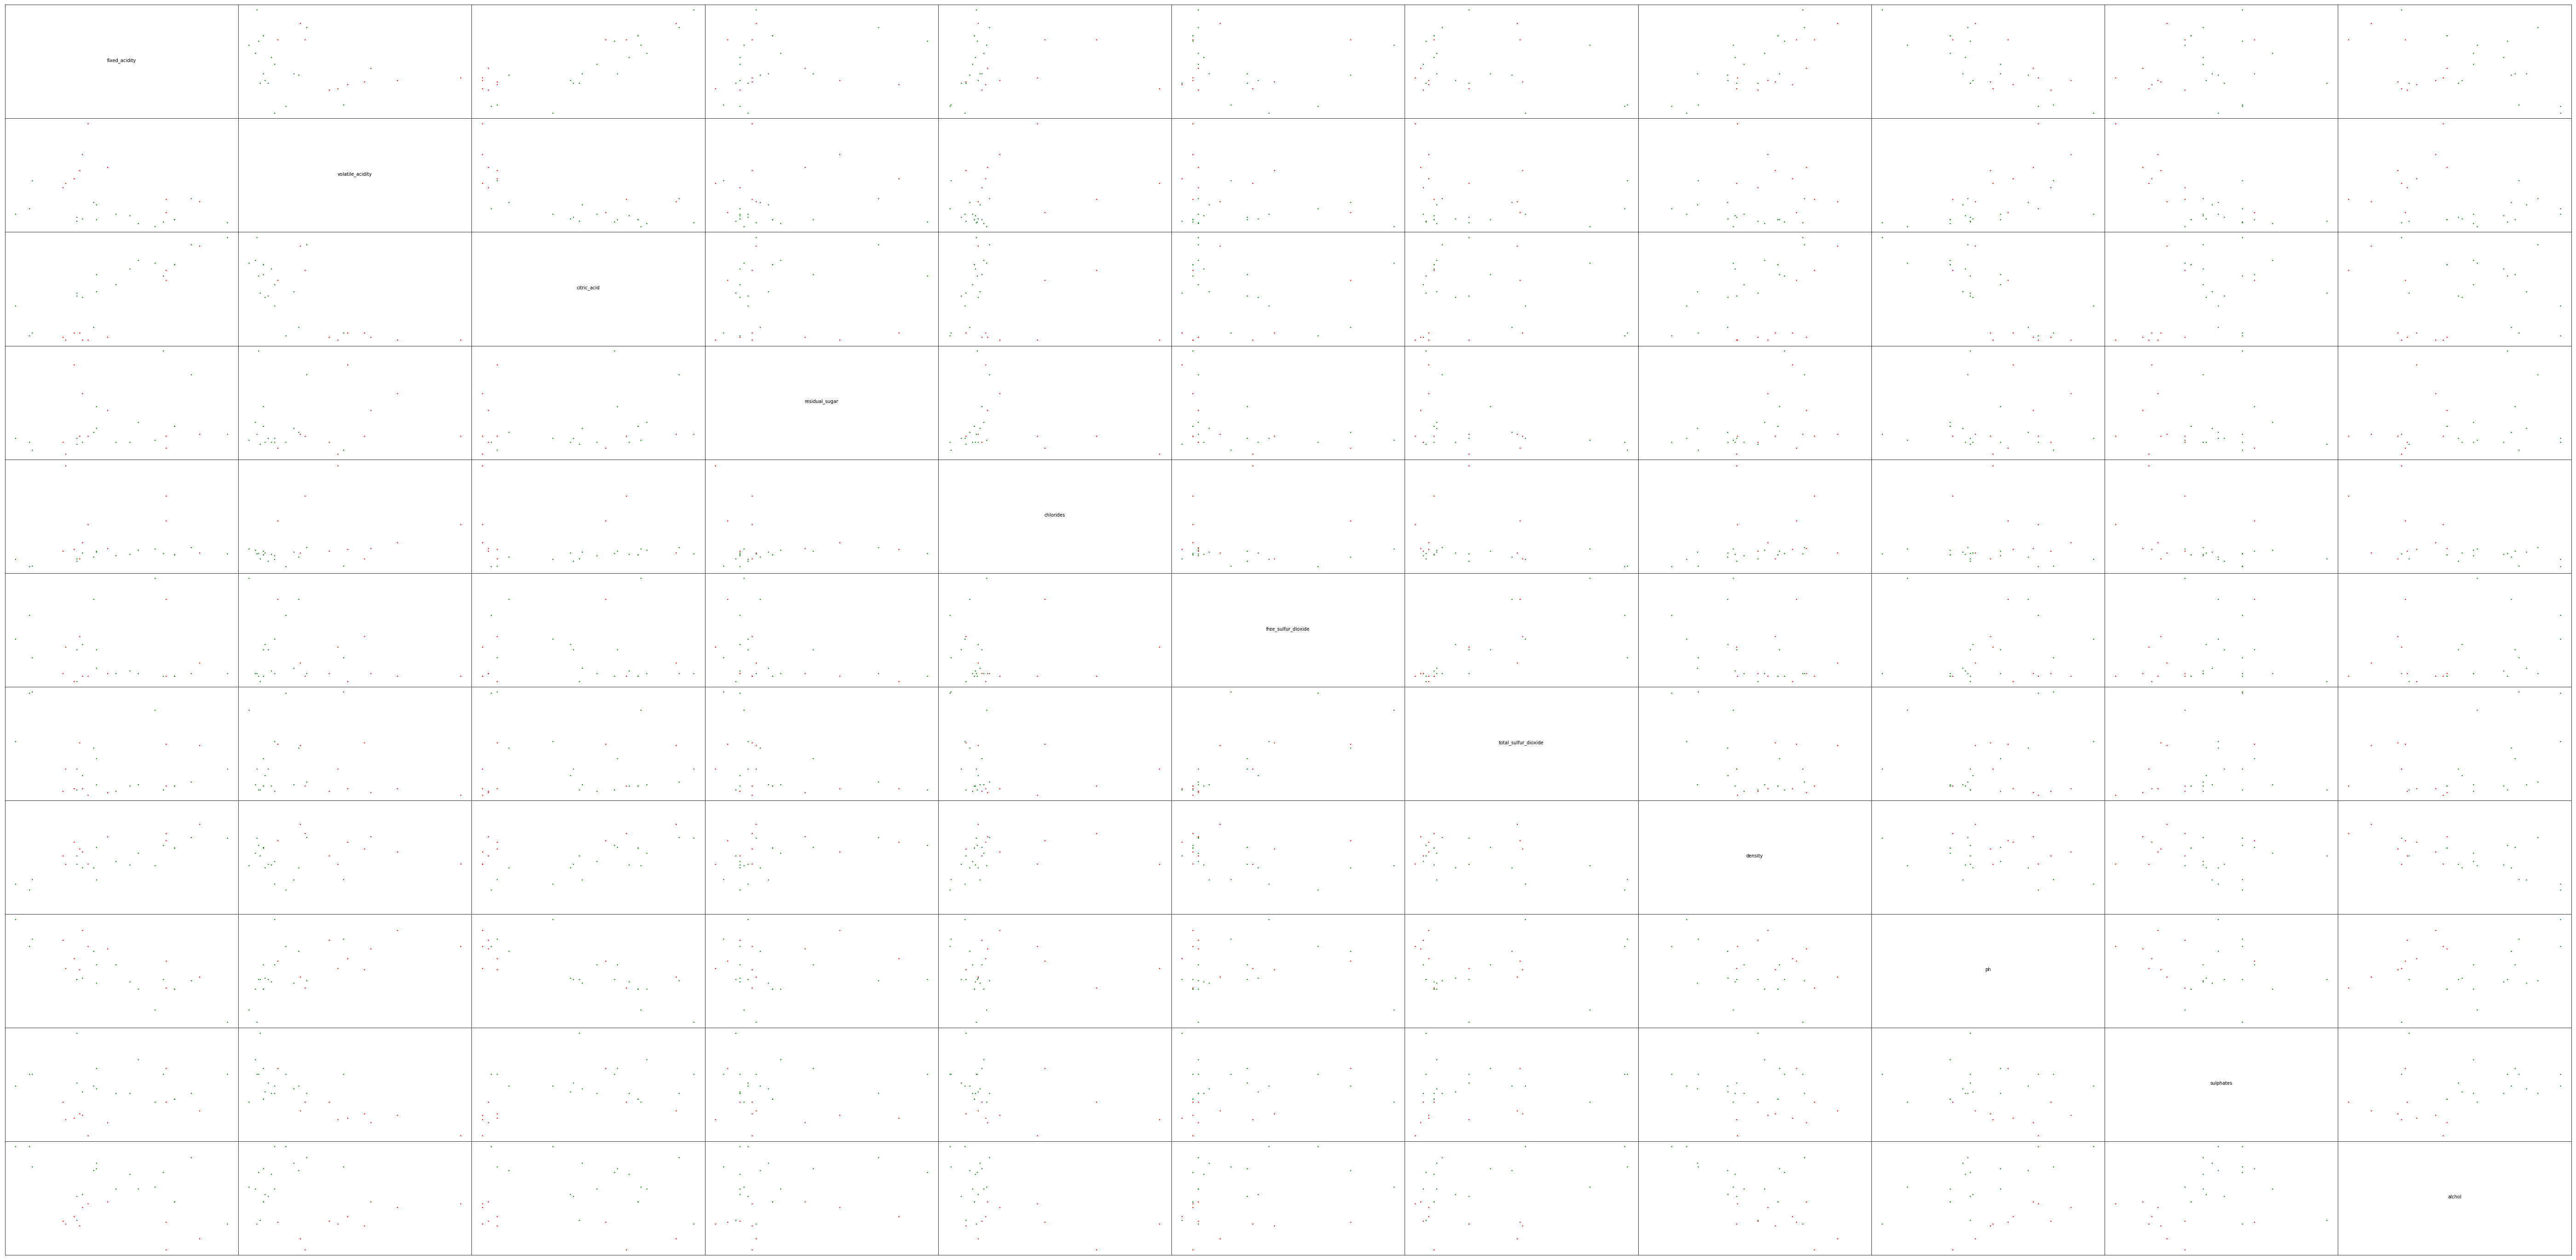

In [2]:
axes = ["fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar", "chlorides", "free_sulfur_dioxide",
        "total_sulfur_dioxide", "density", "ph", "sulphates", "alchol", "quality"]
        
class plot_data:
    x = []
    y = []
    colors = []
    
    def __init__(self, x, y, colors):
        self.x = x;
        self.y = y
        self.colors = colors

def read_file(file):
    wines = []
    with open(file, newline='') as csvfile:
        cread = csv.reader(csvfile, delimiter=';', quotechar='|')
        for row in cread:
            wines.append(row)
    return (wines)
        
wines_red = []
wines_red_file = 'resources/winequality-red.csv'
wines_white = []
wines_white_file = 'resources/winequality-white.csv'

wines_red = read_file(wines_red_file)
wines_white = read_file(wines_white_file)

def get_point_data(wines, xdata, ydata, good_threshold, bad_threshold, save_plot=False):
    x = []
    y = []
    colors = []
    global quality
    
    for wine in wines:
            try:
                x.append(float(wine[xdata]))
                y.append(float(wine[ydata]))
                if int(wine[11]) > good_threshold:
                    colors.append("green")
                elif int(wine[11]) < bad_threshold:
                    colors.append("red")
                else:
                    x = x[:-1]
                    y = y[:-1]
            except:
                if False:
                    print()
    return (plot_data(x, y, colors))

scalar = 2
good = 7
bad = 4

def plot_scatter_matrix(wines, good_threshold, bad_threshold, save_plot=False):
    global axes
    global scalar
    for i in range(0, 11 * 11):
        y = int(i / 11)
        x = i % 11
        ax = plt.subplot(11, 11, i + 1)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        plt.xticks([], [])
        plt.yticks([], [])
        if x == y:
            plt.text(.5, .5, axes[x], ha='center')
        else:
            data = get_point_data(wines, x, y, good_threshold, bad_threshold)
            plt.scatter(data.x, data.y, c=data.colors, s=scalar)
    if save_plot == True:
        plt.savefig('fig.png', dpi=100)
        
fig = plt.figure()
fig.set_size_inches((100, 50))
plt.subplots_adjust(wspace=0, hspace=0)
plot_scatter_matrix(wines_red, good, bad)
plt.show()

## b. Which factors do you think will be most useful to your perceptron for distinguishing high quality vs low quality wines?
Alcohol, and ph seem to be more noticeable factors in wine quality. Sulphates and volatile acidity are also likely to be good choices.

Things like chlorides, density, and sulfur dioxide aren't quite as easy to view their impact linearly, which is what the perceptron model is based on.

# V.2 Learning to perceptron

## a. & b. Implementation and training of a perceptron

In [3]:
axes = ["fixed_acidity", "volatile acidity", "citric_acid", "residual_sugar", "chlorides", "free_sulfur_dioxide",
        "total_sulfur_dioxide", "density", "ph", "sulphates", "alcohol", "quality"]
        
wines_red = []
wines_red_file = 'resources/winequality-red.csv'
wines_white = []
wines_white_file = 'resources/winequality-white.csv'

wines_red = pd.read_csv(wines_red_file, sep=';')
wines_white = pd.read_csv(wines_white_file, sep=';')

epoch = 0
weights = []

def perceptron(wine):
    res = weights[0]
    for i in range(len(wine) - 1):
        res += weights[i + 1] * float(wine[i])
    return 1.0 if res >= 0.0 else 0.0

def train(data, l_rate=.01):
    sum_error = 0.0
    for i in range(len(data)):
        prediction = perceptron(data.iloc[i, :])
        error = prediction - data.iloc[i, -1]
        sum_error += error ** 2
        weights[0] = weights[0] - l_rate * error
        for j in range(len(data.columns) - 1):
            weights[j + 1] = weights[j + 1] - l_rate * error * data.iloc[i, j]
    return sum_error

def train_run(data, epochs=-1, l_rate=.01, verbose=False):
    performance = []
    i = 0
    while True:
        err = train(data, l_rate)
        performance.append([i, err, weights.copy()])
        if i % 250 == 0 and verbose is True:
            print("Err: {}, Epoch: {}, Weights: {}".format(err, i, weights))
        if err == 0 or i == epochs:
            print("Err: {}, Epoch: {}, Weights: {}".format(err, i, weights))
            break
        i += 1
    return performance

def train_perceptron(data, features, seed=-1, l_rate=0.01):
    global weights
    if seed is not -1:
        random.seed(seed)
    weights = [random.uniform(-1, 1) for i in range(len(data.columns) - 1)]
    features[2] = 'binary_quality'
    return train_run(data.loc[:, features], l_rate=l_rate)

good_threshold = 7
bad_threshold = 4
wine_data = wines_red

features = ['alcohol', 'pH', 'quality']
train_data = wine_data.loc[:, features].copy()
train_data = train_data.loc[(train_data['quality'] > good_threshold) | (train_data['quality'] < bad_threshold)]
train_data['binary_quality'] = train_data['quality'].map({good_threshold + 1: 1, bad_threshold - 1: 0})
performance = train_perceptron(train_data, features, seed=1000)

Err: 0.0, Epoch: 12416, Weights: [6.214713285401039, 1.727651119118566, -7.271720792145436]


## c. Write a function that will take the output of your training data and generate two plot in one figure. First plot is number of errors, second is decision boundary.

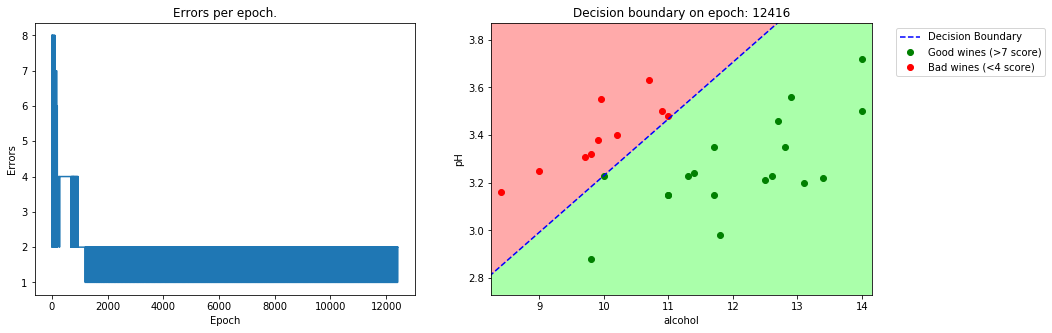

In [4]:
def normal(omin, omax, nmin, nmax, oval):
    x = (((oval - omin) * (nmax - nmin)) / (omax - omin) + nmin)
    return x

def plot_perceptron(data, features, tdata, epoch=-1, savefile=False, savename=None):
    errs = list(zip(*data))[1]
    if epoch < 0:
        epoch = len(errs) - 1
    errs = errs[:epoch]
    weight = data[epoch][2]
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].plot(errs)
    ax[0].set_ylabel('Errors')
    ax[0].set_xlabel('Epoch')
    ax[0].set_title('Errors per epoch.')
    xdatab = []
    ydatab = []
    xdatag = []
    ydatag = []
    for i, row in tdata.iterrows():
        if row['quality'] == good_threshold + 1:
            xdatag.append(row[features[0]])
            ydatag.append(row[features[1]])
        else:
            xdatab.append(row[features[0]])
            ydatab.append(row[features[1]])
    x_min = tdata.loc[:, features[0]].min() - 0.15
    x_max = tdata.loc[:, features[0]].max() + 0.15
    y_min = tdata.loc[:, features[1]].min() - 0.15
    y_max = tdata.loc[:, features[1]].max() + 0.15
    w1 = data[epoch][2][1]
    w2 = data[epoch][2][2]
    b = data[epoch][2][0]
    slope = -w1/w2
    intercept = -b/w2
    x_coords = range(int(x_min) - 1, int(x_max) + 2)
    y_coords = slope * x_coords + intercept
    ax[1].plot(x_coords, y_coords, 'b--', label="Decision Boundary")
    ax[1].set_ylabel(features[1])
    ax[1].set_xlabel(features[0])
    ax[1].set_xlim([x_min, x_max])
    ax[1].set_ylim([y_min, y_max])
    ax[1].fill_between(x_coords, y_coords, y_min, color='#aaffaa')
    ax[1].fill_between(x_coords, y_coords, y_max, color='#ffaaaa')
    ax[1].scatter(xdatag, ydatag, c='green', label="Good wines (>{} score)".format(good_threshold))
    ax[1].scatter(xdatab, ydatab, c='red', label="Bad wines (<{} score)".format(bad_threshold))
    ax[1].set_title('Decision boundary on epoch: {}'.format(epoch))
    ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2)
    
    if savefile and savename:
        plt.savefig(savename)
    return fig

features = ['alcohol', 'pH', 'quality']
fig = plot_perceptron(performance, features, train_data)

## d. Feature Scaling

In [5]:
def normalize(series):
    return (series - series.mean()) / (series.max() - series.min())

Err: 0.0, Epoch: 13, Weights: [0.12471328540112749, 0.5328749711593156, -0.77459069010955]


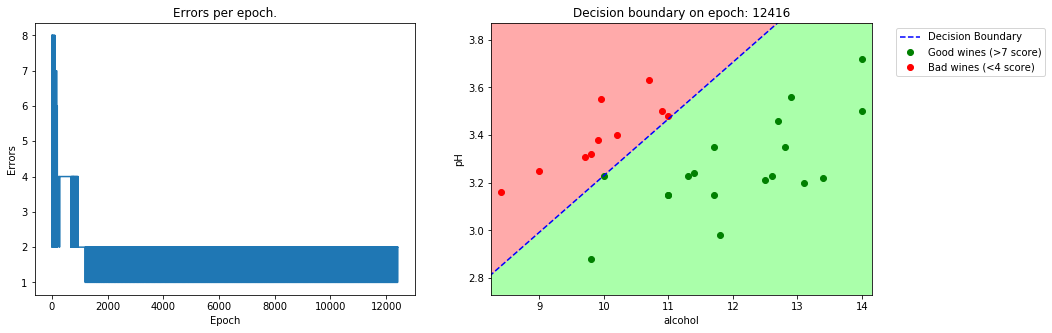

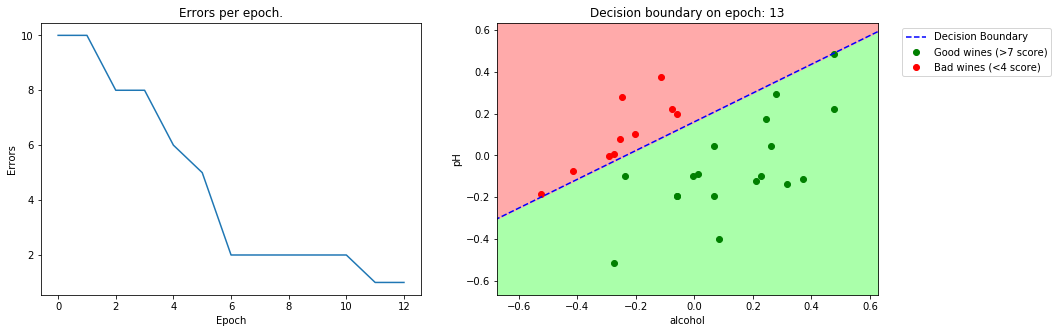

In [6]:
new_data = train_data.copy()
new_data[features[0]] = normalize(new_data[features[0]])
new_data[features[1]] = normalize(new_data[features[1]])

performance_old = performance.copy()
performance_new = train_perceptron(new_data, features, seed=1000)

fig = plot_perceptron(performance_old, features, train_data)
fig = plot_perceptron(performance_new, features, new_data)

# VI.2 Do perceptrons dream of electric sheep?

MovieWriter ffmpeg unavailable. Trying to use html instead.


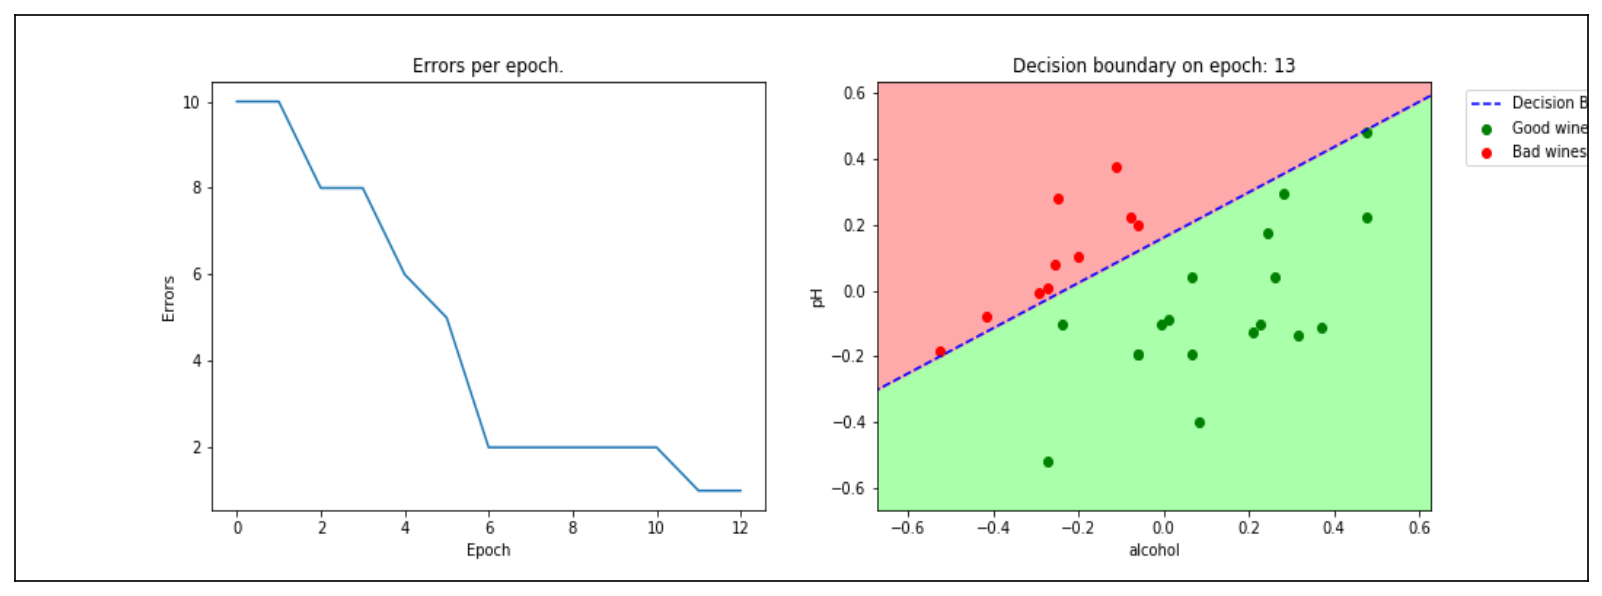

In [7]:
def array_init(shape):
    new_shape = shape
    if isinstance(shape, int):
        new_shape = (shape, 1)
    
    base_dict = {}
    for i in range(new_shape[1]):
        base_dict[i] = new_shape[0] * [0.0]
    
    df = pd.DataFrame.from_dict(base_dict)
    
    if isinstance(shape, int) or isinstance(shape, tuple) and len(shape) == 1:
        return df.values.squeeze()
    return df.values
        

def make_animation(data, features, tdata, outputfile="anim.html", frames=-1):
    fig = plt.figure(figsize=(15,5), dpi=150)
    ax = plt.gca()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    if frames == -1:
        frames = len(data)
    
    def init():
        imobj.set_data(array_init((360, 1000)))

        return imobj,
    
    def animate(i):
        fname = "./train_stats_{}.png".format(i)
        f = plot_perceptron(data, features, tdata, epoch=i, savename=fname, savefile=True)
        img = mpimg.imread(fname)[-1::-1]
        imobj.set_data(img)
        os.remove(fname)
        plt.close(f)
        
        return imobj,
    
    imobj = ax.imshow(array_init((360, 1000)), interpolation='bilinear',
                      origin='lower', alpha=1.0, zorder=1, aspect=1)
    
    anim = animation.FuncAnimation(fig, animate, init_func=init, repeat=False, blit=True, interval=250,
                    frames=range(int(frames)))
    
    anim.save(outputfile)

make_animation(performance_new, features, new_data)

# V.3 My fair ADALINE

## a. 
The perceptron algorithm is a linear classifier. Which does not work if the data is not linearly seperable. In the case of wines of 4 and lower and 7 and higher there is data that cannot be seperated linearly. Thus a perfect error rate of 0 can never be reached.

## b. Implement ADALINE